In [25]:
# 크롤링에 필요한 패키지 설치
from bs4 import BeautifulSoup
from newspaper import Article
from time import sleep
from time import time
from multiprocessing import Pool
import json
import requests
import re
import sys
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import chromedriver_autoinstaller
import subprocess
import shutil
import random
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.by import By
import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도
import seaborn as sns

In [4]:
from pytrends.request import TrendReq
import pandas as pd

# hl = host language, tz = timezone
pytrends = TrendReq(hl='ko', tz=360)

In [5]:
data = pytrends.trending_searches(pn='south_korea') # Japan
data

,0
0,최태원
1,이승기
2,이영희 삼성전자
3,윤여정
4,이상민
5,김의겸
6,일본 대 크로아티아
7,한국 브라질
8,음바페
9,잉글랜드 세네갈


In [6]:
data[:10]

,0
0,최태원
1,이승기
2,이영희 삼성전자
3,윤여정
4,이상민
5,김의겸
6,일본 대 크로아티아
7,한국 브라질
8,음바페
9,잉글랜드 세네갈


In [7]:
def crawl_news(query: str=None, crawl_num: int=300, workers: int=4):
    '''뉴스 기사 텍스트가 담긴 list를 반환합니다.

    Keyword arguments:
    query -- 검색어 (default None)
    crawl_num -- 수집할 뉴스 기사의 개수 (defualt 1000)
    workers -- multi-processing시 사용할 thread의 개수 (default 4)
    '''

    url = 'https://search.naver.com/search.naver?where=news&sm=tab_jum&query={}'
    articleList = []
    crawled_url = set()
    keyboard_interrupt = False
    t = time()
    idx = 0
    page = 1


    # 서버에 url 요청의 결과를 선언
    res = requests.get(url.format(query))
    sleep(0.5)
    # res를 parsing할 parser를 선언
    bs = BeautifulSoup(res.text, 'html.parser')

    with Pool(workers) as p:
        while idx < crawl_num:
            table = bs.find('ul', {'class': 'list_news'})
            li_list = table.find_all('li', {'id': re.compile('sp_nws.*')})
            area_list = [li.find('div', {'class':'news_area'}) for li in li_list]
            a_list = [area.find('a', {'class':'news_tit'}) for area in area_list]

            for n in a_list[:min(len(a_list), crawl_num-idx)]:
                articleList.append(n.get('title'))
                idx += 1
            page += 1

            pages = bs.find('div', {'class': 'sc_page_inner'})
            next_page_url = [p for p in pages.find_all('a') if p.text == str(page)][0].get('href')

            req = requests.get('https://search.naver.com/search.naver' + next_page_url)
            bs = BeautifulSoup(req.text, 'html.parser')
    return articleList

In [95]:
query = data[0][4]

articleList = crawl_news(query)

df_articleList = pd.DataFrame(articleList,columns = ['제목'])
df_articleList

,제목
0,"이상민 문책, '해임'건의냐 '탄핵'이냐…고심 깊어진 野"
1,"스텝 꼬인 野, 다시 '이상민 탄핵소추'로 직행 가능성↑"
2,"공무원 노조, 총투표 공권력으로 집요하게 방해, 투표 참여자 징계 강요 이상민 장관 고발"
3,막판 예산 협상 속도…이상민 해임건의안 힘겨루기
4,이상민 해임건의 건너뛰고 탄핵 직행하나... 민주당의 딜레마
...,...
295,"대통령실, 野 '이상민 해임건의안'에 ""국정조사 의사 있나"""
296,"[단독] ""이상민 해임 안 되면 탄핵…법률 검토도 마쳤다"""
297,"주호영 ""민주당, 이상민 탄핵소추안 내면 예산안 타협 어려워"""
298,"이상민 놓고 與野 의견차↑, 예산안 처리 불투명 [정치오늘]"


In [96]:
documents = list(df_articleList["제목"]) #파일 읽기, 불러오기
documents[0]

"이상민 문책, '해임'건의냐 '탄핵'이냐…고심 깊어진 野"

In [97]:
import numpy as np
from konlpy.tag import Okt
okt = Okt() ## konlpy 형태소 분리하는 라이브러리
from PIL import Image
import nltk
import re

In [98]:
data[0][0]

'최태원'

In [99]:
FEATURE_POS = ["Noun", "Verb", "Adverb", "Adjective"]


def text_cleaning(doc):
    # 한국어를 제외한 글자를 제거하는 패턴.
    doc = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", doc)

    # 특수문자를 제거하는 패턴.
    #doc = re.sub("[\{\}\[\]\/?.,;:|\)*~`!^\-_+<>@\#$%&\\\=\(\'\"]", " ", doc)

    # 영문 빼고 모두 제거하는 패턴.
    #doc = doc.replace("\n", " ")
    #doc = re.sub("[^A-Za-z ]", "", doc)

    return doc

def define_stopwords(path):
    #불용어란 문장에서 큰 의미가 없는 단어들이다.
    #https://www.ranks.nl/stopwords/korean 불용어들 링크
    SW = set()
    # 불용어를 추가하는 방법 1.
    # SW.add("있다")
    SW.add(data[0][0])
    SW.add(data[0][1])
    SW.add(data[0][2])
    SW.add(data[0][3])
    SW.add(data[0][4])

    # 불용어를 추가하는 방법 2.
    # stopwords-ko.txt에 직접 추가

    with open(path, encoding="utf-8") as f:
        for word in f:
            SW.add(word.strip())

    return SW

def text_tokenizing(doc, tokenizer):
    """
    Input Parameter :

    doc - tokenizing 하는 실제 데이터.
    tokenizer - token의 단위.
    """
    # tokenizer이란? 문자열을 여러개의 조각으로 나누는 것
    # 여기서 나눠진 문자열의 한 조각이 token 이다.

    if tokenizer == "words": #띄어쓰기에 따라 조각을 나눔, 단어 추출
        return [word for word in doc.split() if word not in SW and len(word) > 1]

    elif tokenizer == "nouns": # okt.nouns() 이용하여 명사 추출
        return [word for word in okt.nouns(doc) if word not in SW and len(word) > 1]

    elif tokenizer == "morphs": #okt.morphs() 이용하여 형태소 추출
        return [word for word in okt.morphs(doc) if word not in SW and len(word) > 1]


    elif tokenizer == "predefined": #o 이용하여


        documents = []
        text_pos = [pair for pair in okt.pos(doc) if pair[0] not in SW and len(pair[0]) > 1]
        words = []

        for word, pos in text_pos:
            if pos in FEATURE_POS:
                words.append(word)

        return words

In [100]:
tokenizer = "nouns" # "words" / "nouns" / "morphs" / "predefined"
#문자열을 나누는 여러가지 방법중 nouns 사용

In [101]:
SW = define_stopwords(r"C:\Users\yoon9\Documents\GitHub\News-clipping-service-based-on-Google-Trends\src\stopwords-ko.txt")
tokenized_documents = [text_tokenizing(text_cleaning(doc), tokenizer=tokenizer) for doc in documents]
tokenized_documents[0], len(tokenized_documents)

(['문책', '해임', '건의', '탄핵', '고심'], 300)

In [102]:
from pprint import pprint ##pprint 란 데이터형태인 json 파일을 더 예쁘게 출력할 때 사용한다!

kor_total_tokens = [] #tokens 들을 모을 리스트
for token_doc in tokenized_documents:
    kor_total_tokens += token_doc

text = nltk.Text(kor_total_tokens)
print(f"Total {tokenizer} : ", len(text.tokens)) #총 나온 명사의 빈도
print(f"Total Unique {tokenizer} : ", len(set(text.tokens))) #그 중에서 특별한 명사의 등장 빈도
pprint(text.vocab().most_common(10))

Total nouns :  1885
Total Unique nouns :  399
[('해임', 138),
 ('탄핵', 95),
 ('건의', 71),
 ('장관', 71),
 ('예산안', 45),
 ('예산', 41),
 ('민주', 38),
 ('여야', 32),
 ('민주당', 30),
 ('처리', 30)]


In [103]:
from nltk import FreqDist

# 빈도 출력 갯수.
topN = 50

x = []
y = []
wordInfo = dict()

for vocab, count in text.vocab().most_common(topN):
    x.append(vocab)
    y.append(count)
    wordInfo[vocab] = count

test = {"Counts" : x, "Samples" : y}
print(x[:5])
print(y[:5])

['해임', '탄핵', '건의', '장관', '예산안']
[138, 95, 71, 71, 45]


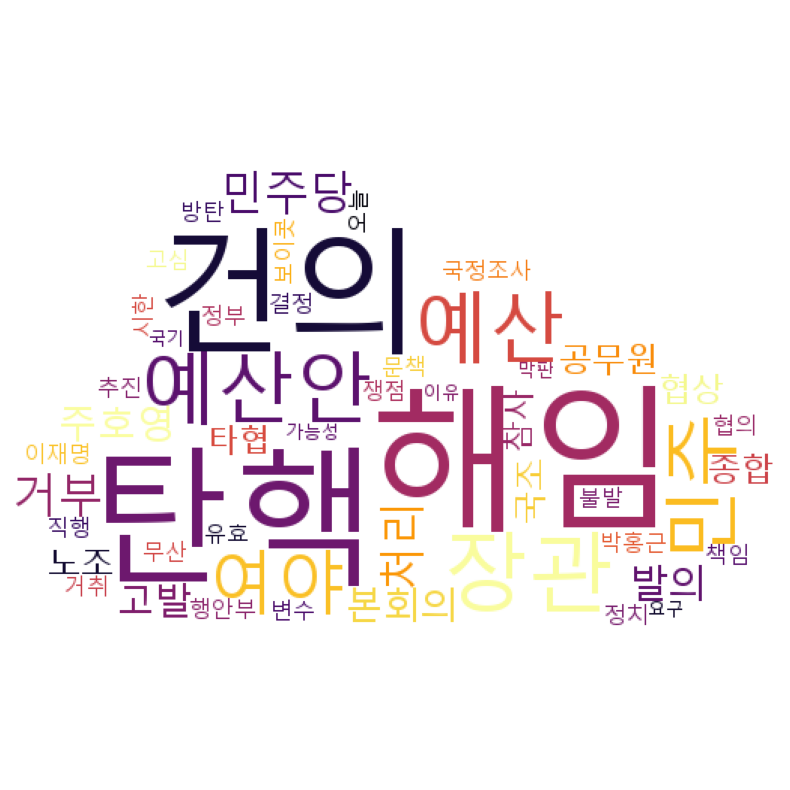

In [105]:
from wordcloud import WordCloud
path = r"C:\Windows\Fonts\malgun.ttf"

mask = np.array(Image.open(r"C:\Users\yoon9\Documents\GitHub\News-clipping-service-based-on-Google-Trends\src\cloud.png")) #이미지 불러오기
wordcloud = WordCloud(font_path = path,
                      relative_scaling = 0.2,
                      #stopwords=STOPWORDS,
                      mask=mask,
                      background_color='white',
                      colormap=plt.cm.inferno
                      ).generate_from_frequencies(wordInfo) #wordinfo에 저장된 tokens 들에 빈도수에 따라 크기가 달라지도록
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
#plt.savefig(fr"C:\Users\yoon9\Documents\GitHub\News-clipping-service-based-on-Google-Trends\src\WordCloud image\wordcloud_{query}.png")
plt.show()